In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
import plotly.express as px

In [626]:
data = pd.read_csv("./data/cars_about_2.csv").dropna()
data = data[data.price != "Not Priced"]

data.price = data.price.map(lambda a: int(a.replace("$", "")))
# binarize used_label
data.used_label = data.used_label.apply(lambda a: int(a=="Used"))
# split brand name from whole name of a car
data["brand"] = data.car_model.apply(lambda a: a.split()[0])
# remove cols because they are useful
cars_global = data['car_id']
data = data.drop(["car_model", "car_id"], axis=1)

In [627]:
data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,engine,mileage;,brand
0,1,39,Red,Black,Front-wheel Drive,19.0,27,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,29403;,Toyota
1,1,49,Shadow Black,Black,Four-wheel Drive,19.0,24,Gasoline,10-Speed Automatic,3.5L V6 24V PDI DOHC Twin Turbo,32929;,Ford
2,1,41,Granite Crystal Clearcoat Metallic,Black,Four-wheel Drive,15.0,21,Gasoline,8-Speed Automatic,5.7L V8 16V MPFI OHV,23173;,RAM
3,1,28,Gray,–,Front-wheel Drive,29.0,35,Gasoline,Automatic CVT,1.5L I4 16V GDI DOHC Turbo,10598;,Honda
4,1,49,Eminent White Pearl,Birch,Front-wheel Drive,20.0,27,Gasoline,8-Speed Automatic,3.5L V6 24V PDI DOHC,28137;,Lexus
...,...,...,...,...,...,...,...,...,...,...,...,...
401,0,30,Super White,Nutmeg,All-wheel Drive,34.0,30,Hybrid,Automatic CVT,2.5L I4 16V MPFI DOHC Hybrid,41944;,Toyota
402,1,35,Black,Black,All-wheel Drive,22.0,29,Gasoline,9-Speed Automatic,2.0L I4 16V GDI DOHC Turbo,49386;,Cadillac
403,1,35,Tungsten Metallic,Jet Black,Four-wheel Drive,16.0,22,Gasoline,6-Speed Automatic,5.3L V8 16V GDI OHV,115795;,Chevrolet
404,1,9,Green,Black,Front-wheel Drive,23.0,28,Gasoline,Automatic,2.0L DOHC MPI dual-CVVT 16-valve I4 engine -in...,47786;,Kia


In [628]:
categotical_cols = [column_name for column_name in data.columns if isinstance(data[column_name].iloc[0], str)]
 
for column in categotical_cols:
    data[column] = data[column].apply(str.lower)
    
label_encoders = dict(zip(
    categotical_cols, [LabelEncoder().fit(data[column_name]) for column_name in categotical_cols]
))

In [629]:
for column_name in categotical_cols:
    data[column_name] = label_encoders[column_name].transform(data[column_name])

In [630]:
data['minMPG'] = data['minMPG'].astype('int')

In [631]:
data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,engine,mileage;,brand
0,1,39,139,10,4,19,15,3,18,60,166,28
1,1,49,145,10,3,19,12,3,2,62,202,10
2,1,41,62,10,3,15,9,3,18,89,130,25
3,1,28,66,82,4,29,23,3,25,4,11,13
4,1,49,53,9,4,20,15,3,18,60,160,19
...,...,...,...,...,...,...,...,...,...,...,...,...
401,0,30,163,56,1,34,18,5,25,28,267,28
402,1,35,11,10,1,22,17,3,21,14,305,5
403,1,35,168,48,3,16,10,3,8,86,33,6
404,1,9,68,10,4,23,16,3,23,9,296,17


Выбираю оптимальное количество кластеров методов "Elbow". 

По моему мнению, оптимальным является значение 8

In [277]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import Birch

In [681]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform="pandas")

data_norm = scaler.fit_transform(data)

In [648]:
data_norm_ids = np.concatenate([data_norm, cars_global.astype('int').to_numpy()[:, np.newaxis]], axis=1)

In [649]:
data_norm_ids[0]

array([ 0.34465132,  0.17322026,  1.01168048, -0.92172187,  0.86489203,
       -0.24772848, -0.10084253,  0.05914417,  0.19990887,  0.42610592,
       -0.29957828,  1.40561051,  1.        ])

In [158]:
def normalize(x:pd.DataFrame)-> pd.DataFrame:
    df = x.copy()
    for col in df.columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = (df[col] -mean)/std
    return df

In [160]:
data_norm = normalize(data)

In [577]:
params_db = {'algorithm': 'auto',
 'eps': 0.2,
 'leaf_size': 5,
 'metric': 'correlation',
 'metric_params': None,
 'min_samples': 3,
 'n_jobs': None,
 'p': None}

In [578]:
db = DBSCAN()
db = db.set_params(**params_db)
db = db.fit(data_norm)

In [579]:
labels = db.labels_
 
n_clusters = np.unique(labels).size
n_clusters

24

In [457]:
import itertools
from tqdm import tqdm
params = {}
num_clusters = [0]
num_noise = [406]
for eps, samples in tqdm(itertools.product(range(1, 12),range(3, 15))):
    
    ep = eps/10
    metric = 'correlation'
    db = DBSCAN(eps=ep, min_samples=samples, metric=metric, leaf_size=5).fit(data_norm)
    labels = db.labels_
 
    n_clusters = np.unique(labels).size
    n_noise_ = list(labels).count(-1)
    if n_clusters > 6 and n_noise_ < 75:print("clusters: %d" % n_clusters, "noise points: %d" % n_noise_,"samples %d" % samples, f"eps {ep}", f"metric {metric}", sep='\t')

    
    # print()
        
    if n_clusters_ > 3 or n_noise_ < min(num_noise):
        params[f"{n_clusters_=}  {n_noise_=}  {samples=}"] = [eps, samples]
        

68it [00:00, 318.38it/s]

clusters: 12	noise points: 51	samples 3	eps 0.2	metric correlation
clusters: 11	noise points: 68	samples 4	eps 0.2	metric correlation


132it [00:00, 309.86it/s]


In [684]:
birch_model = Birch(threshold=2.7, n_clusters=24, branching_factor=3).set_output(transform="pandas")
transformed = birch_model.fit_transform(data_norm)

/home/sapfear/miniconda3/envs/rec/lib/python3.11/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning:

Number of subclusters found (21) by BIRCH is less than (24). Decrease the threshold.



In [718]:
transformed

,birch0,birch1,birch2,birch3,birch4,birch5,birch6,birch7,birch8,birch9,...,birch11,birch12,birch13,birch14,birch15,birch16,birch17,birch18,birch19,birch20
0,2.034044,2.747951,8.291046,8.760726,3.964133,4.977407,2.689579,3.270395,3.389194,4.694309,...,4.058680,4.601674,3.954973,5.153599,2.136967,2.748314,3.397108,4.945258,6.737946,3.038113
1,2.467546,3.532879,7.866886,8.319049,2.243434,4.198937,2.860334,3.023243,3.059658,4.637273,...,4.302992,3.804721,4.732787,5.023520,2.654286,4.026249,3.571501,5.678867,6.742210,4.023982
2,2.686311,3.638668,8.800324,8.575010,3.801503,4.815253,1.768213,2.905790,2.572087,4.035537,...,3.798024,3.377176,4.415927,5.517403,2.414682,3.096046,3.918379,4.911990,6.556887,3.159376
3,4.040380,5.222393,8.888038,9.636334,5.059243,6.770228,6.216132,4.520714,4.498259,6.851108,...,5.503706,6.306587,4.372406,7.504246,3.733294,4.403286,3.408712,6.776747,7.532434,2.867560
4,2.135572,3.464209,8.251768,8.689640,3.417230,5.224647,2.958513,3.251646,2.215403,4.300836,...,3.819625,3.338923,3.862732,5.326464,1.678692,2.751397,2.826143,5.326728,6.734740,2.746668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,6.261599,5.699108,10.378022,11.375567,6.743938,6.147192,7.096569,6.327086,6.649719,6.482631,...,5.350873,7.686635,4.613899,5.945500,6.134756,5.689735,6.152501,8.529030,11.360856,5.626669
402,3.923964,3.482427,9.357809,9.569434,4.160894,6.149773,5.127256,4.526076,3.310418,5.503133,...,4.755912,3.662397,4.353441,5.900621,3.133335,2.540946,1.890934,6.707569,7.472396,3.259782
403,2.293716,4.276783,8.420962,8.526911,2.647280,3.755112,3.416356,2.123718,3.304264,5.478728,...,4.341053,4.488173,4.935539,6.225905,3.069378,4.658791,4.155175,5.481433,6.276901,3.795325
404,3.383696,3.233684,10.140578,9.878551,5.140630,6.347383,4.724037,4.846967,4.456975,5.518129,...,5.439640,5.367833,4.065924,6.444712,2.692308,2.211741,2.274912,5.919519,7.183431,3.536271


In [719]:
labels = [transformed.iloc[i].argmin() for i in range(len(transformed))]
    

In [698]:
transformed['birch5'].unique().min()

1.1563970076591956

In [690]:
transformed.iloc[0].to_numpy().min()

2.0340443600092377

In [710]:
labels = birch_model.labels_
centroids = birch_model.subcluster_centers_
n_clusters = np.unique(labels).size
print("n_clusters : %d" % n_clusters)

n_clusters : 21


In [713]:
center_labels = birch_model.subcluster_labels_

In [712]:
centroids_ids = [transformed.loc[transformed[col] == transformed[col].min()].index[0] for col in transformed.columns]

In [714]:
center_label2id = {center_labels[i]:centroids_ids[i] for i in range(len(center_labels))}

In [715]:
center_label2id

{0: 125,
 1: 279,
 2: 65,
 3: 171,
 4: 80,
 5: 92,
 6: 135,
 7: 335,
 8: 359,
 9: 184,
 10: 231,
 11: 142,
 12: 126,
 13: 293,
 14: 153,
 15: 12,
 16: 219,
 17: 84,
 18: 45,
 19: 60,
 20: 191}

In [705]:
for p in range(birch_model.subcluster_centers_.shape[0]):
    for i in range(len(data_norm)):

            row = data.iloc[i].to_numpy()
            # print(row == inverse_centers[p]
            try:
                if (row.round(3) == birch_model.subcluster_centers_[p].round(3)).all():
                # if  == set(centers[0]):
                    print(i, p)
            except:
                print('error')

In [272]:
db = DBSCAN(eps=0.2, min_samples=3, metric='correlation', algorithm='brute').fit_predict(data_norm)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

In [617]:
birch_model.subcluster_labels_

array([16, 13,  1,  0,  2, 17, 19, 20,  6,  5,  3, 23,  3,  2,  6,  5, 18,
        1,  0, 15,  9, 22,  2, 12, 21, 10,  7,  4,  8, 11, 14])

In [729]:
len(labels)

405

In [600]:
birch_data = birch_model.predict(data_norm)

In [619]:
birch_data[149]

5

In [735]:
import random
n_users = 75
n_centroids_user = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8], n_users, [0.2, 0.2, 0.2,0.05, 0.07, 0.07, 0.07, 0.07, 0.07])
n_cars_user = np.random.choice(list(range(3, 20)), n_users)

data = {'car_id':[],
        'user_id':[]}
# 1
# 5
# 1
# 5 -1 - 1

for user_id in range(n_users):
    n_centroids = n_centroids_user[user_id]
    
    n_cars = np.random.choice(list(range(n_centroids, 20)), 1)[0]
    
    try:
        n_noise = np.random.choice(list(range(0, n_cars //2)), 1)[0]
    except:
        n_noise = 0
    
    user_center_ids = np.random.choice(center_labels, n_centroids)
    
    n_clean_cars = n_cars - n_noise - n_centroids
    
    if len(user_center_ids) > 1:
        main_center = np.random.choice(user_center_ids, 1)[0]
    else:
        main_center = user_center_ids[0]
    
    for center_car in user_center_ids:
        data['car_id'].append(center_label2id[center_car])
        data['user_id'].append(user_id)
            
    # for noise_car in range(n_noise):
    for normal_car in range(n_clean_cars):
        if n_clean_cars > labels.count(main_center):
            n_cars_from_centroid = int(labels.count(main_center)*(0.75))
            ids =[]
            
            for id_, label in enumerate(labels):
                if len(ids) == n_cars_from_centroid:
                    break
                    
                else:
                    if label == main_center:
                        ids.append(id_)
                        data['car_id'].append(id_)
                        data['user_id'].append(user_id)
                        
            n_other_cars = n_clean_cars - n_cars_from_centroid
            ind_others = np.random.choice(list(range(1, 405)), n_other_cars+3)
            for ind_ in ind_others:
                data['car_id'].append(labels[ind_])
                data['user_id'].append(user_id)
                        
            
    # birch_data

In [736]:
df = pd.DataFrame(data)

In [738]:
df.to_csv("dataset.csv")

In [727]:
g = [1, 1, 1, 14, 5,5,  6]
g.index(5, g.count(5))

4

In [ ]:


labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

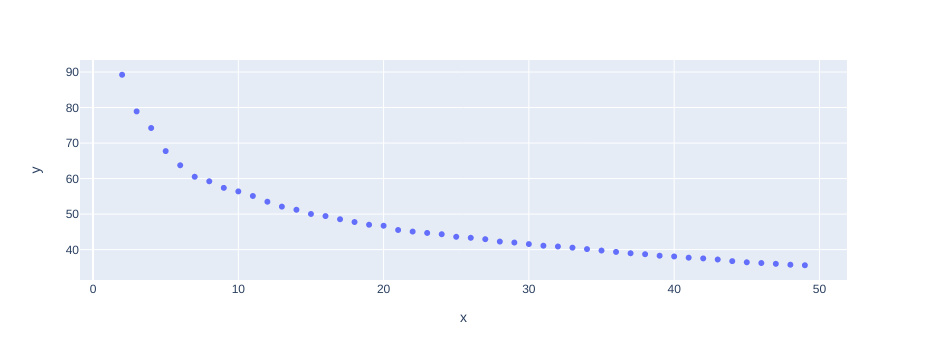

In [31]:
res = list()
n_cluster = range(2,50)

for n in n_cluster:
    kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(data)
    res.append(np.average(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)))

fig = px.scatter(x=n_cluster, y=res)
fig.show()

In [23]:
kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(data)

In [24]:
labels = pd.DataFrame(kmeans.labels_) 
labeled_data = pd.concat((data,labels),axis=1)
labeled_data = labeled_data.rename({0:'labels'},axis=1)

In [25]:
labeled_data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,engine,mileage,brand,labels
0,1,39,139,10,4,19.0,27.0,3,18,60,29403.0,28,1
1,1,49,145,10,3,19.0,24.0,3,2,62,32929.0,10,1
2,1,41,62,10,3,15.0,21.0,3,18,89,23173.0,25,1
3,1,28,66,82,4,29.0,35.0,3,25,4,10598.0,13,3
4,1,49,53,9,4,20.0,27.0,3,18,60,28137.0,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,1,33,46,10,3,18.0,25.0,3,18,66,43807.0,16,5
400,0,30,163,56,1,34.0,30.0,5,25,28,41944.0,28,5
401,1,35,11,10,1,22.0,29.0,3,21,14,49386.0,5,5
402,1,35,168,48,3,16.0,22.0,3,8,86,115795.0,6,0


In [26]:
fig = px.scatter_matrix(labeled_data,color='labels')
fig.update_layout(
    width=1800,
    height=1800,
    hovermode='closest',
)
fig.show()

/home/proton/anaconda3/envs/proton/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

